In [59]:
reset -fs

# Load libraries

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.formula.api as smf
import statsmodels.api as sms
from scipy.stats import norm
import collections
from scipy import stats
from scipy.stats import ttest_1samp
%matplotlib inline

# Load data 

In [61]:
#load the file, we need two data sets
horse = pd.read_csv('race-result-horse.csv')
race = pd.read_csv('race-result-race.csv')

# 1, Data cleanning

In [62]:
horse.head(2)

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,running_position_2,running_position_3,running_position_4,finish_time,win_odds,running_position_5,running_position_6,race_id
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133.0,1032.0,1.0,-,1.0,2.0,2.0,1.0,1.22.33,3.8,NaN,NaN,2014-001
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,2,8.0,9.0,9.0,2.0,1.22.65,8.0,NaN,NaN,2014-001


In [63]:
race.head(2)

,src,race_date,race_course,race_number,race_id,race_class,race_distance,track_condition,race_name,track,sectional_time,incident_report
0,20140914-1.html,2014-09-14,Sha Tin,1,2014-001,Class 5,1400,GOOD TO FIRM,TIM WA HANDICAP,"TURF - ""A"" COURSE",13.59 22.08 23.11 23.55,\n When about to enter the trac...
1,20140914-10.html,2014-09-14,Sha Tin,10,2014-010,Class 2,1400,GOOD TO FIRM,COTTON TREE HANDICAP,"TURF - ""A"" COURSE",13.55 22.25 22.89 22.85,\n SMART MAN was slow to begin....


### This two table is connected by "race_id", let's connect them together. I really don't need much from the race table except the "race_distance" and the "race_course" columns. I also don't need certain columns from the horse table, I will drop them as well. We will take a look at the table now.

In [64]:
horse_race = horse.merge(race[['race_id', 'race_distance', 'race_course']], suffixes=('', '_y'))
horse_race.drop(['length_behind_winner','running_position_1','running_position_2','running_position_3',
           'running_position_4','running_position_5','running_position_6', 'horse_name'], axis = 1, inplace = True)
horse_race.head(2)

,finishing_position,horse_number,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,finish_time,win_odds,race_id,race_distance,race_course
0,1,1.0,K019,B Prebble,D Cruz,133.0,1032.0,1.0,1.22.33,3.8,2014-001,1400,Sha Tin
1,2,2.0,S070,D Whyte,D E Ferraris,133.0,1075.0,13.0,1.22.65,8.0,2014-001,1400,Sha Tin


### Looking at the data types of each column, some needs to change to the appropriate data type in order to perform analysis. Such columns include "finish_time", needs to be floats in seconds; "draw", be in strings as I will treat it as a categorical variable.

In [65]:
horse_race.dtypes

finishing_position        object
horse_number             float64
horse_id                  object
jockey                    object
trainer                   object
actual_weight            float64
declared_horse_weight    float64
draw                     float64
finish_time               object
win_odds                 float64
race_id                   object
race_distance              int64
race_course               object
dtype: object

In [66]:
def convert_time(time_string):
    '''a function to convert string time to seconds'''
    return float(time_string.split('.')[0]) * 60 + float(time_string.split('.')[1]) + float(time_string.split('.')[2]) / 100

horse_race = horse_race[horse_race.finish_time != '---']
horse_race.finish_time = horse_race.finish_time.apply(convert_time)
horse_race.draw = horse_race.draw.apply(str)

# 2, Feature selection and plotting.

In [67]:
#Let's look at the categorical variables(distance, horse name, trainer, draw)

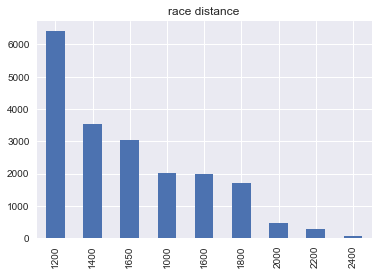

In [68]:
horse_race.race_distance.value_counts().plot(kind = 'bar', title = 'race distance');

In [69]:
#let's focus only on the 1200 race results. 
horse_race = horse_race[horse_race.race_distance == 1200]

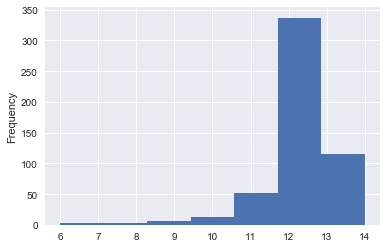

In [70]:
#let's look at the draw column
horse_race.groupby(['race_id']).draw.count().plot(kind = 'hist', bins = 7);

In [71]:
#select out 12 for simplicity, we only focus on race that have 12 horses
t = horse.groupby(['race_id']).draw.count()
t = pd.DataFrame(t)
t = t[t.draw == 12]
horse_12 = horse_race[horse_race.race_id.isin(t.index)]
horse_12.head()

,finishing_position,horse_number,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,finish_time,win_odds,race_id,race_distance,race_course
108,1,13.0,P224,J Moreira,J Moore,116.0,1137.0,7.0,68.90,2.5,2014-008,1200,Sha Tin
109,2,7.0,S263,Z Purton,T P Yung,123.0,1190.0,6.0,69.01,9.0,2014-008,1200,Sha Tin
110,3,2.0,N288,B Prebble,C Fownes,129.0,1115.0,9.0,69.37,3.4,2014-008,1200,Sha Tin
111,4,6.0,P058,M Chadwick,A S Cruz,124.0,1091.0,4.0,69.41,7.7,2014-008,1200,Sha Tin
112,5,12.0,S279,H W Lai,K L Man,115.0,1040.0,5.0,69.48,9.0,2014-008,1200,Sha Tin


In [72]:
print('# of unique horse:', len(horse_12.horse_id.unique()))
print('# of unique trainer:', len(horse_12.trainer.unique()))

# of unique horse: 1036
# of unique trainer: 24


### probability time

In [73]:
#given there are 1036 unique horses, what is the probability that if I randomly choose a horse, it had participated 
#more than one race. 
outcome1 = sum(horse_12.groupby(['horse_id']).apply(len) == 1)
sample_space = len(horse_12.horse_id.unique())
probability = 1 - outcome1/sample_space
probability

0.68822393822393824

In [74]:
# Fitting that many categories is not feasible, I need to reduce the # of them.
def top(data, top_level):
    return data.value_counts()[:top_level].index
horse_12 = horse_12[horse_12.horse_id.isin(top(horse_12.horse_id, 30))]

In [75]:
horse_12.race_course.value_counts()

Happy Valley    299
Sha Tin         177
Name: race_course, dtype: int64

In [76]:
#Let's look at the numeric variable

In [77]:
horse_12[['declared_horse_weight','finish_time']].describe()

,declared_horse_weight,finish_time
count,476.000000,476.000000
mean,1102.968487,70.487437
std,56.176011,0.878836
min,983.000000,68.090000
25%,1059.750000,69.960000
50%,1096.000000,70.540000
75%,1148.000000,71.042500
max,1245.000000,73.250000


# Let's do a hypothesis testing here. By Looking at the above table, I suspect that the mean winning time is less than or equal to 69. 

$H_0 : \mu \leq 69$;
 
$H_1 : \mu > 69$

In [78]:
#Let's get the winning data
horse_winning = horse_12[horse_12.finishing_position == '1']
horse_winning.head()
t,p = ttest_1samp(horse_winning.finish_time, 69)
p

6.739816641804065e-11

### We reject the null since p-value is so small, let's graph it and take a visual look.

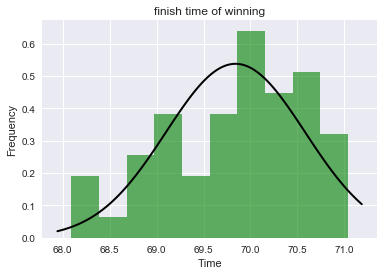

In [79]:
# plot a distribution and fit a normal curve to it
def norm_graph(data, title, axe = None):
    data.plot(kind = 'hist', color = 'green', normed= True, alpha = .6)
    m,s = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, m, s)
    plt.plot(x, p, 'k', linewidth=2);
    plt.title(title);
    plt.xlabel('Time')

norm_graph(horse_winning.finish_time, 'finish time of winning')

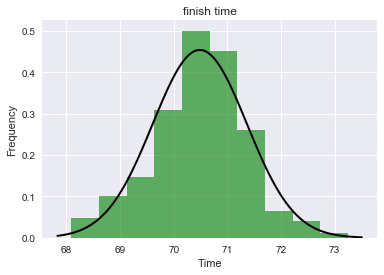

In [80]:
#we can visualize the finish time of all the horses 
norm_graph(horse_12.finish_time, 'finish time')

# Looks like it is approximately normal, let's look at the weight as well. 

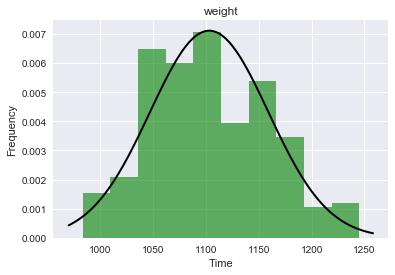

In [81]:
# Noticed even for the same horse, its weight is changing.
norm_graph(horse_12.declared_horse_weight, 'weight')

### The distribution of weight is left skewed.  Given this two graphs, it is reasonably enough to say that both the y vairable "time" and the x variable "weight" is continous and normally distributed.  

# Let's look at the relation between Y and Xs.

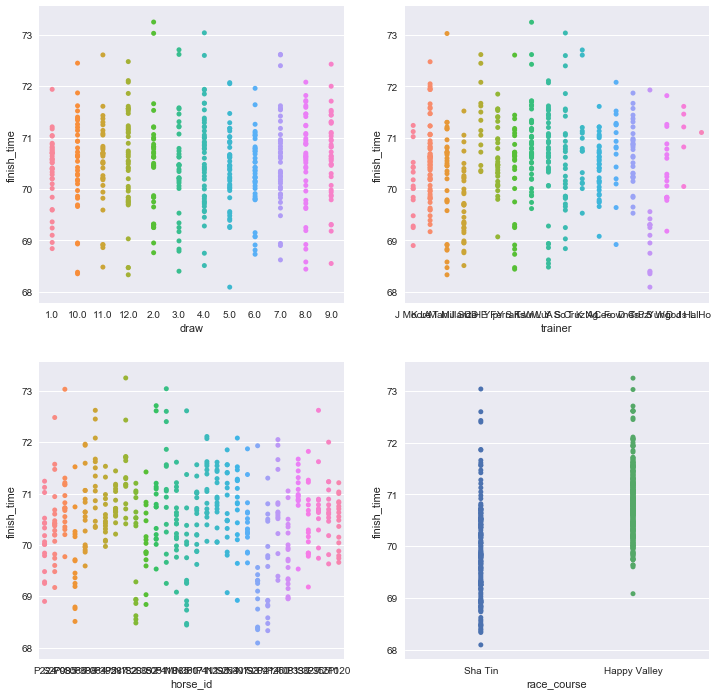

In [82]:
fig,ax = plt.subplots(2,2, figsize = (12,12))
sn.stripplot(x="draw", y="finish_time", data=horse_12, ax = ax[0][0]);
sn.stripplot(x="trainer", y="finish_time", data=horse_12, ax = ax[0][1]);
sn.stripplot(x="horse_id", y="finish_time", data=horse_12, ax = ax[1][0]);
sn.stripplot(x="race_course", y="finish_time", data=horse_12, ax = ax[1][1]);

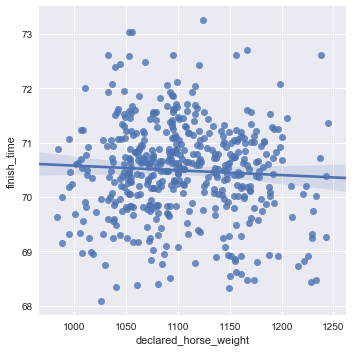

In [83]:
sn.lmplot(x="declared_horse_weight", y="finish_time", data=horse_12);

In [84]:
# Based on the above graph, it might be possible that weight is not a good predictor for time.
# Correlation also states that the relation between them is weak. 
np.corrcoef(horse_12.declared_horse_weight, horse_12.finish_time)

array([[ 1.        , -0.05554074],
       [-0.05554074,  1.        ]])

# Let's start our regression

In [85]:
model = smf.ols(formula = 'finish_time ~ declared_horse_weight + trainer + horse_id + draw + race_course', data = horse_12)

In [86]:
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            finish_time   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     8.855
Date:                Wed, 08 Mar 2017   Prob (F-statistic):           1.67e-38
Time:                        14:24:36   Log-Likelihood:                -457.35
No. Observations:                 476   AIC:                             1007.
Df Residuals:                     430   BIC:                             1198.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  61.1221      3.042     20.095      0.000        55.144    67.100
trainer[T.A S Cruz]         0.7291      0.209      3.491      0.001         0.319     1.140
trainer[T.A T Millard]      0.1707      0.154      1.109      0.268        -0.132     0.473
trainer[T.C Fownes]        -0.0509      0.129     -0.394      0.694        -0.305     0.203
trainer[T.C H Yip]          0.8596      0.190      4.533      0.000         0.487     1.232
trainer[T.D Cruz]           0.4964      0.168      2.962      0.003         0.167     0.826
trainer[T.D E Ferraris]     0.4493      0.330      1.363      0.174        -0.199     1.097
trainer[T.D J Hall]         0.5539      0.308      1.801      0.072        -0.051     1.159
trainer[T.J Moore]         -0.0286      0.116     -0.248      0.804        -0.256     0.199
trainer[T.J Size]           0.4188      0.232      1.805      0.072        -0.037     0.875
trainer[T.K L Man]          0.8779      0.262      3.348      0.001         0.363     1.393
trainer[T.K W Lui]          0.4568      0.154      2.959      0.003         0.153     0.760
trainer[T.L Ho]             0.4564      0.664      0.688      0.492        -0.848     1.761
trainer[T.S Woods]          0.3837      0.160      2.402      0.017         0.070     0.698
trainer[T.T K Ng]           0.1621      0.119      1.359      0.175        -0.072     0.397
trainer[T.T P Yung]         0.0046      0.178      0.026      0.979        -0.345     0.354
trainer[T.W Y So]           0.3348      0.167      2.003      0.046         0.006     0.663
trainer[T.Y S Tsui]        -0.3016      0.430     -0.701      0.483        -1.147     0.543
horse_id[T.N182]            0.8243      0.163      5.055      0.000         0.504     1.145
horse_id[T.N193]            0.0592      0.150      0.393      0.694        -0.237     0.355
horse_id[T.N295]            0.7189      0.231      3.111      0.002         0.265     1.173
horse_id[T.N307]           -0.0509      0.129     -0.394      0.694        -0.305     0.203
horse_id[T.N360]           -0.6642      0.457     -1.453      0.147        -1.563     0.234
horse_id[T.P064]            0.8596      0.190      4.533      0.000         0.487     1.232
horse_id[T.P085]            1.0010      0.215      4.665      0.000         0.579     1.423
horse_id[T.P120]           -0.0718      0.231     -0.311      0.756        -0.525     0.381
horse_id[T.P171]           -0.6330      0.196     -3.227      0.001        -1.019    -0.247
horse_id[T.P214]           -0.8302      0.165     -5.047      0.000        -1.154    -0.507
horse_id[T.P224]           -0.0286      0.116     -0.248      0.804        -0.256     0.199
horse_id[T.P260]            0.2426      0.188      1.292      0.197        -0.127     0.612
horse_id[T.P287]            0.8013      0.455  

### Let's do some prediction at the end. 

In [96]:
weight = np.linspace(983, 1245, 10000)[np.random.randint(0,10000)]
horse = horse_12.horse_id.unique()[np.random.randint(0,30)]
course = horse_12.race_course.unique()[np.random.randint(0,2)]
draw = horse_12.draw.unique()[np.random.randint(0,12)]
trainer = horse_12.trainer.unique()[np.random.randint(0,24)]
test_table = pd.DataFrame(data = [[weight,trainer, horse, draw, course]], columns = ['declared_horse_weight', 'trainer', 'horse_id', 'draw', 'race_course'])
test_table

,declared_horse_weight,trainer,horse_id,draw,race_course
0,1098.50115,J Moore,S051,5.0,Happy Valley


In [97]:
model.fit().predict(test_table)

array([ 70.26916509])